# Intro

The initial dataset being sourced is from the HuggingFace library, (https://huggingface.co/datasets/brianarbuckle/cocktail_recipes)

This initial dataset contains columns `title`, `ingredients`, `directions`, `misc`, `source`, and `ner`.

**Overview**
The 'Ingredients' column of our dataset presents a unique challenge. It consists of objects, each being a list of strings, where each string details a part of a cocktail recipe. These details typically include the quantity, unit, and name of an ingredient, but they can also contain preparation instructions or garnishing details that are not directly usable in their current form for data analysis or recipe generation.

**Objective**
Our goal is to parse these strings to extract structured information that can be effectively utilized in our project. Specifically, we aim to separate the ingredient details into distinct components: quantity, unit, and ingredient name, while filtering out the non-ingredient related information.

## Imports

In [1]:
import pandas as pd
import re
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Initial Data Inspection

In [2]:
# Loading the cocktail_recipes dataset
dataset = load_dataset('brianarbuckle/cocktail_recipes')

df = pd.DataFrame(dataset['train'])

In [3]:
df.head(5)

,title,ingredients,directions,misc,source,ner
0,151 Swizzle,[1.5 oz. 151-Proof Demerara Rum [Lemon Hart or...,[],[],Beachbum Berry Remixed,"[pernod, rum]"
1,20th Century,"[The 21st Century, 2 oz. Siete Leguas Blanco T...","[shake on ice and strain into coupe , The Best...",[],Jim Meehan,"[cocchi americano, pernod, tequila]"
2,20th Century,"[1.5 oz. Plymouth Gin, 3\/4 oz. Mari Brizard W...",[shake on ice and strain],[],PDT,"[lillet, gin]"
3,Abbey Cocktail,[],"[Shake liquid ingredients with ice., Strain in...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,[]
4,Absinthe Drip,[1 1/2 ounces Pernod (or other absinthe substi...,[Pour Pernod into a pousse-caf or sour glass....,[The Absinthe Drip was made famous by Toulouse...,The Ultimate Bar Book,"[pernod, absinthe]"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        875 non-null    object
 1   ingredients  875 non-null    object
 2   directions   875 non-null    object
 3   misc         875 non-null    object
 4   source       875 non-null    object
 5   ner          875 non-null    object
dtypes: object(6)
memory usage: 41.1+ KB


In [5]:
df.shape

(875, 6)

# Data Cleaning

## Lowercase standardization

Here we remove adjectives and lowercase all ingredients to avoid redundancies. 

In [6]:
def lowercase_ingredients(ingredients_list):
    """
    Converts all strings within a list of ingredients to lowercase.

    This function is useful for standardizing the case of all ingredient entries,
    making the dataset more uniform for analysis or processing.

    Parameters:
    
    ingredients_list (list): A list of ingredient strings.
      Returns:
    A list of ingredients with all strings converted to lowercase.
    """
    # Check if ingredients_list is indeed a list; if not, return it as is
    if not isinstance(ingredients_list, list):
        return ingredients_list

    # Convert each ingredient in the list to lowercase
    lowercase_list = [ingredient.lower() for ingredient in ingredients_list]
    return lowercase_list

# Apply the function to the 'ingredients' column
df['ingredients'] = df['ingredients'].apply(lowercase_ingredients)

## Adjective Removal

To eliminate ingredient redundancies, we are removing adjectives in the following code block:

In [7]:
# Lowercase all items in the ingredient list and remove "fresh"
for index, row in df.iterrows():
    # Update the ingredients list by removing 'fresh' if it exists
    updated_ingredients = [ingredient.replace('fresh ', '') if 'fresh ' in ingredient else ingredient for ingredient in row['ingredients']]
    # Update the DataFrame with the modified ingredients list
    df.at[index, 'ingredients'] = updated_ingredients

## Deleting Empty Rows

### Filtering rows where `Ingredients` is empty

There were two scenarios in the data, ingredients being len of 0, and ingredients being an empty string list (len of 1, being the list, but its still empty).

In [8]:
# Filter rows where `ingredients` is not empty and not just an empty string list
modified_df = df[df['ingredients'].apply(lambda x: len(x) > 0 and x != [''])].reset_index(drop=True)

## Normalization

### Ingredients Lists: Separating Combined Strings

In [9]:
def split_combined_ingredients(ingredients_list):
    """
    Splits a single-item list containing a string of ingredients separated by commas
    into a list of individual ingredients. If the list contains more than one item or
    if the single item does not contain a comma, the original list is returned.

    This is useful for normalizing ingredients lists where all ingredients are combined
    into a single string.

    Parameters:
    - ingredients_list: A list of ingredient(s).

    Returns:
    - A list of separated and trimmed ingredient strings.
    """
    if len(ingredients_list) == 1 and ',' in ingredients_list[0]:
        return [ingredient.strip() for ingredient in ingredients_list[0].split(', ')]
    else:
        return ingredients_list

# Applying the function
modified_df['ingredients'] = modified_df['ingredients'].apply(split_combined_ingredients)

### Deleting ingredients listed as optional 

In [10]:
def filter_optional_ingredients(ingredients_list):
    """
    Filters out ingredients marked as "optional" from a list of ingredients.
    
    This function iterates through a given list of ingredient strings, removing
    any ingredient that contains the word "optional". The goal is to create a more
    concise and essential list of ingredients by excluding those that are not
    crucial to the recipe. This step is part of data cleaning to standardize
    the ingredients data for further analysis.
    
    Parameters:
    - ingredients_list: A list of strings, where each string is an ingredient.

    Returns:
    - A list of ingredient strings, excluding any marked as "optional".
    """
    optional_keyword = 'optional'
    filtered_list = [ingredient for ingredient in ingredients_list if optional_keyword not in ingredient.lower()]
    return filtered_list

# Apply the filtering function to the 'ingredients' column
modified_df['ingredients'] = modified_df['ingredients'].apply(filter_optional_ingredients)


### Defining `delete_ingredients_at_steps` and `delete_row_at`  to delete rows/indexes which are not usable

In [11]:
def delete_row_at(df, row_index):
    """
    Removes a specified row from the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - row_index (int): The index of the row to remove.

    Returns:
    - None; modifies the DataFrame in place.
    """
    # Ensure the row_index is within the DataFrame's range
    if row_index < 0 or row_index >= 871:
        print(f"Delete_row; Row index is out of DataFrame's range. Row = {row_index}")
        return
    
    # Drop the specified row without resetting the index
    df.drop(index=row_index, inplace=True)

In [12]:
def delete_ingredients_at_steps(df, row_index, ingredient_steps):
    """
    Removes ingredients at specified steps (indices) from the list of ingredients
    for a given row in the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the recipe information.
    - row_index (int): The index of the row from which to remove the ingredients.
    - ingredient_steps (list of int): The indices of the ingredients to remove within the ingredients list.
    
    Returns:
    - None; modifies the DataFrame in place.
    """
    # Ensure the row_index is within the DataFrame's range
    if row_index < 0 or row_index >= 871:
        print(f"Delete_ingredients: Row index is out of DataFrame's range. Row = {row_index}")
        return
    
    # Get the current list of ingredients for the specified row
    ingredients_list = df.at[row_index, 'ingredients']
    
    # Check if ingredient_steps is a single integer, wrap it in a list
    if isinstance(ingredient_steps, int):
        ingredient_steps = [ingredient_steps]

    # Ensure ingredients_list is a list
    if not isinstance(ingredients_list, list):
        print("Ingredients are not in list format for the specified row.")
        return
    
    # Remove the ingredients at the specified steps
    # Sort the indices in reverse order to avoid index shift during deletion
    for step in sorted(ingredient_steps, reverse=True):
        # Check each step's validity before attempting to delete
        if step < 0 or step >= len(ingredients_list):
            print(f"Ingredient step {step} is out of range and will not be deleted.")
            continue
        del ingredients_list[step]
    
    # Update the DataFrame in place
    df.at[row_index, 'ingredients'] = ingredients_list

We will be utilizing these two functions in order to delete entries in `ingredients`, or entire rows of the `modified_df` 

#### Looking through indexes of `modified_df` to find indexes/rows to delete

In [13]:
i = 374 # Put in starting index for session

In [14]:
# Use this to check row [n] of modified_df['ingredients']
print(f"Index {i}")
ingredients = modified_df['ingredients'][i]
print(ingredients)


# Display the function calls with the dynamic length of the ingredients list
print(f"\n\ndelete_ingredients_at_steps(modified_df, {i}, [0]) #") 
print(f"\ndelete_ingredients_at_steps(modified_df, {i}, [{len(ingredients)-1}]) #") # Assuming you want to pass the length directly
print(f"\ndelete_row_at(modified_df, {i}) #")

i += 1

Index 374
['1 oz. sugar syrup', '3 oz. sselected liquor', '2 or 3 cloves', '1 dash ground cinnamon', 'combine in goblet or highball galss', 'fill with water', 'garnish with grated nutmeg']


delete_ingredients_at_steps(modified_df, 374, [0]) #

delete_ingredients_at_steps(modified_df, 374, [6]) #

delete_row_at(modified_df, 374) #


### Deleting/modifying entries utilzing `delete_ingredients_at_steps` and `delete_row_at` 

In [15]:
delete_ingredients_at_steps(modified_df, 0, [6, 7])
delete_ingredients_at_steps(modified_df, 1, [0,4])
delete_ingredients_at_steps(modified_df, 3, [3]) # spoon
delete_ingredients_at_steps(modified_df, 5, [6,7])
delete_row_at(modified_df, 6)
delete_row_at(modified_df, 7)
delete_row_at(modified_df, 8)
delete_row_at(modified_df, 10)

delete_row_at(modified_df, 13)
delete_ingredients_at_steps(modified_df, 15, [3,4,5,6,7,8,9,10,11]) # commentary steps
delete_row_at(modified_df, 16) # recipie is in parts (3/4 dry gin, 1/4 yellow chartreuse)
delete_row_at(modified_df, 17) # odd steps, seems like steps w/o ingredients

delete_ingredients_at_steps(modified_df, 20, [3]) # 'shake on ice'
delete_ingredients_at_steps(modified_df, 21, [3]) # 'From'
delete_ingredients_at_steps(modified_df, 22, [3,4]) # Shake on ice and strain, garnish with pineapple leaf

delete_ingredients_at_steps(modified_df, 33, [3,4])
delete_row_at(modified_df, 34)
delete_ingredients_at_steps(modified_df, 36, [4])
delete_ingredients_at_steps(modified_df, 37, [4])

delete_row_at(modified_df,41) # substitute x ingredient with y
# delete_ingredients_at_steps(modified_df, 43, [7,8]) # lime wedge and avocado slice

delete_row_at(modified_df,51) # Not enough information
delete_ingredients_at_steps(modified_df,53,[4])
delete_row_at(modified_df, 56) # parts
delete_row_at(modified_df, 57) # parts

delete_row_at(modified_df, 61) # parts
delete_row_at(modified_df, 63) # x but y
delete_ingredients_at_steps(modified_df, 64, [0]) #name
delete_row_at(modified_df, 65) #no ingredients
delete_ingredients_at_steps(modified_df, 66, [0]) #name
delete_row_at(modified_df, 68) #no ingredients

delete_row_at(modified_df, 71) # fraction

delete_row_at(modified_df, 80) # fraction
delete_ingredients_at_steps(modified_df, 82, [0]) # cocktail introduction
delete_row_at(modified_df, 83) # syntax
delete_ingredients_at_steps(modified_df, 84, [0,1,2]) # Descriptive step
delete_row_at(modified_df, 85) # X but Y
delete_row_at(modified_df, 86) # x but with y 

delete_row_at(modified_df, 90) # x but with y 
delete_row_at(modified_df, 92) # Recipe in parts 
delete_row_at(modified_df, 93) # Fraction
delete_row_at(modified_df, 97) # Fraction
delete_ingredients_at_steps(modified_df, 98, [0]) # Descriptive step; steps also include "2 to 3 ounces, 2 to 3 dashes etc.
delete_row_at(modified_df, 99) # x but with y 

delete_ingredients_at_steps(modified_df, 102, [0]) #says its a variation
delete_row_at(modified_df, 108) # Recipie in parts
delete_ingredients_at_steps(modified_df, 109, [3]) # 'stir and strain'

delete_row_at(modified_df, 111) # weird steps no ingredient
delete_row_at(modified_df, 113) # no ingredients
delete_ingredients_at_steps(modified_df, 115, [0]) # flavour text
delete_row_at(modified_df, 117) # X but with Y
delete_row_at(modified_df, 119) # Parts

delete_ingredients_at_steps(modified_df, 122, [0]) # description
delete_row_at(modified_df, 127) # X but with Y

delete_ingredients_at_steps(modified_df, 131, [0]) # Descriptive step
delete_ingredients_at_steps(modified_df, 135, [4]) # Descriptive step
delete_row_at(modified_df, 137) # Recipe in parts 
delete_row_at(modified_df, 139) # Fraction

delete_row_at(modified_df, 140) # Fraction
delete_row_at(modified_df, 141) # history lesson
delete_row_at(modified_df, 143) # parts
delete_row_at(modified_df, 145) # Recipe in parts; also has dashes of ingredients; might need to revisit
delete_ingredients_at_steps(modified_df, 147, [0]) # Descriptive step
delete_row_at(modified_df, 148) # Fraction

delete_row_at(modified_df, 152) # Contains ingredients but written in descriptive language
delete_ingredients_at_steps(modified_df, 156, [0]) # Descriptive step 
delete_row_at(modified_df, 158) # Recipe x but with y ingredient
delete_row_at(modified_df, 159) # Recipe x but with y ingredient

delete_row_at(modified_df, 162) # Fraction
delete_row_at(modified_df, 164) # Recipe x but with y ingredient
delete_row_at(modified_df, 165) # Contains ingredients but written in descriptive language
delete_row_at(modified_df, 168) # Recipe x but with y ingredient
delete_row_at(modified_df, 169) # Recipe x but with y ingredient

modified_df.at[175, 'ingredients'] = [ingredient.replace("teaspooon", "teaspoon") for ingredient in modified_df.at[175, 'ingredients']]     # fix typo
delete_row_at(modified_df, 184) # Parts
delete_row_at(modified_df, 187) # Recipie x but with y ingredient

delete_row_at(modified_df, 193) # Parts
delete_row_at(modified_df, 196) # Weird recipie format, can manually fix if we want
delete_row_at(modified_df, 198) # Parts

delete_row_at(modified_df, 200) #this is not a recipie
delete_row_at(modified_df, 201) # Parts + index 1/2/3 not ingredients
delete_row_at(modified_df, 204) # X but with Y
delete_row_at(modified_df, 207) # Parts 
delete_ingredients_at_steps(modified_df, 208, [5])
delete_ingredients_at_steps(modified_df, 209, [5,6])

delete_ingredients_at_steps(modified_df, 210, [5]) # not ingredient step
delete_ingredients_at_steps(modified_df, 211, [3]) # COULD FIX, 'few drops' as unit & measurement
delete_row_at(modified_df, 212) # Parts
delete_row_at(modified_df, 215) # Parts
delete_ingredients_at_steps(modified_df, 218, [0]) # history of creation

delete_ingredients_at_steps(modified_df, 220, [0]) # alternate name
delete_ingredients_at_steps(modified_df, 224, [0]) # inspired by..
delete_row_at(modified_df, 225) # this is not a recipie
delete_row_at(modified_df, 228) # Parts, BUT WINE GLASS NOT COCKTAIL GLASS!

delete_ingredients_at_steps(modified_df, 230, [4]) # Rinse glass w/ 
delete_row_at(modified_df, 234) # X but with Y
delete_ingredients_at_steps(modified_df, 236, [3,4]) #re-lists ingredient 0, and empty value
delete_row_at(modified_df, 239) # X but with Y

delete_ingredients_at_steps(modified_df, 240, [0]) # lore
delete_row_at(modified_df, 241) # parts
delete_ingredients_at_steps(modified_df, 242, [3]) # shake on ice and strain
delete_ingredients_at_steps(modified_df, 243, [3, 4]) # shake,  garnish
delete_ingredients_at_steps(modified_df, 245, [3]) # shake on ice and strain
delete_row_at(modified_df, 248) # X but with Y

delete_row_at(modified_df, 250) # doesent contain ingredients
delete_row_at(modified_df, 253) # history
delete_row_at(modified_df, 254) # parts
delete_row_at(modified_df, 256) # parts
delete_ingredients_at_steps(modified_df, 258, [0]) # history 

delete_row_at(modified_df, 260) # Parts
delete_row_at(modified_df, 261) # X but with Y
delete_ingredients_at_steps(modified_df, 263, [5]) # empty space as a index
delete_row_at(modified_df, 266) # X but with Y
delete_row_at(modified_df, 268) # THIS IS FIXABLE, ITS JUST NOT LISTED RIGHT, MANUAL FIX REQ
delete_row_at(modified_df, 269) # X but with Y

delete_ingredients_at_steps(modified_df, 271, [0,1]) # History
delete_row_at(modified_df, 272) # [0] is parts, rest is history
delete_row_at(modified_df, 273) # X but with Y
delete_row_at(modified_df, 274) # X but with Y
delete_row_at(modified_df, 277) # X but with Y, salvagable
delete_row_at(modified_df, 278) # Manual fix required (indexed wrong, flavor text. but has ingredients)

delete_ingredients_at_steps(modified_df, 280, [7,8,9,10]) # Descriptive step
delete_ingredients_at_steps(modified_df, 282, [4]) # Descriptive step
delete_row_at(modified_df, 283) # X but Y
delete_row_at(modified_df, 285) # x but y + weird description
delete_row_at(modified_df, 286) # X but y
delete_row_at(modified_df, 288) # parts + description 
delete_row_at(modified_df, 289) # manual fix required, can salvage

delete_row_at(modified_df, 290) # Parts
delete_row_at(modified_df, 298) # X but Y

delete_row_at(modified_df, 300) # delete index 0, full recipie is in index 1 need to split it up MANUAL FIX REQ
delete_ingredients_at_steps(modified_df, 301, [0]) # saying name alternative
delete_row_at(modified_df, 304) # MANUAL FIX REQUIRED, entire recipie in index 3, measurement not placed normally
delete_row_at(modified_df, 306) # full recipie in [0]
delete_row_at(modified_df, 309) # X but Y

delete_row_at(modified_df, 312) # x but y
modified_df.at[314, 'ingredients'] = [ingredient.replace("and 2 ounces peach brandy.", "2 ounces peach brandy") for ingredient in modified_df.at[314, 'ingredients']]
delete_row_at(modified_df, 316) # parts
delete_row_at(modified_df, 317) # parts

delete_row_at(modified_df, 321) # no ingredients
delete_ingredients_at_steps(modified_df, 322, [0,1,2,3,4]) # history
delete_row_at(modified_df, 324) # x but y
delete_row_at(modified_df, 327) # no recipie
delete_row_at(modified_df, 328) # x but y
delete_row_at(modified_df, 329) # x but y

delete_ingredients_at_steps(modified_df, 332, [3]) # stir
delete_row_at(modified_df, 333) # a or b, not really a recipie
delete_ingredients_at_steps(modified_df, 334, [2,3,6]) # not ingredient steps
delete_row_at(modified_df, 338) # no ingredients

delete_row_at(modified_df, 340) #x but with y
delete_ingredients_at_steps(modified_df, 341, [0]) #name
delete_row_at(modified_df, 344) #x but with y  
delete_row_at(modified_df, 345) #x but with y
delete_row_at(modified_df, 347) #x but with y 
delete_ingredients_at_steps(modified_df, 348, [0]) #name/description
delete_ingredients_at_steps(modified_df, 349, [0]) #name/description

delete_row_at(modified_df, 350) #duplicate
delete_ingredients_at_steps(modified_df, 353, [0]) #name/description
delete_row_at(modified_df, 354) #x but with y
delete_ingredients_at_steps(modified_df, 355, [0]) #name/description
delete_row_at(modified_df, 356) # Might parse incorrectly
delete_row_at(modified_df, 358) #fractions

delete_ingredients_at_steps(modified_df, 360, [0,4,8,9]) #name, none, none, description
delete_row_at(modified_df, 361) # Manual fix required
delete_row_at(modified_df, 364) # Manual fix required
modified_df.at[365, 'ingredients'] = ['lemon twist' if ingredient.startswith('lemon twist variation:') else ingredient for ingredient in modified_df.at[365, 'ingredients']]
delete_row_at(modified_df, 368) #fractions
delete_ingredients_at_steps(modified_df, 369, [2,3]) #Empty steps

delete_ingredients_at_steps(modified_df, 370, [5]) #This is just funny
delete_ingredients_at_steps(modified_df, 372, [4]) #Ice ingredient
delete_ingredients_at_steps(modified_df, 374, [4,5,6]) #Mix/dilute steps
modified_df.at[374, 'ingredients'] = [ingredient.replace("sselected", "selected") for ingredient in modified_df.at[374, 'ingredients']]
delete_ingredients_at_steps(modified_df, 375, [3]) #Mix/dilute step
delete_ingredients_at_steps(modified_df, 377, [5,6,7]) #Recipe steps
delete_ingredients_at_steps(modified_df, 378, [2]) #Recipe step

delete_row_at(modified_df, 380) #Disgusting cocktail
delete_ingredients_at_steps(modified_df, 383, [0]) #name
delete_ingredients_at_steps(modified_df, 384, [0]) #name
delete_ingredients_at_steps(modified_df, 387, [5]) #rinse step
delete_row_at(modified_df, 389) #not enough info for other ingredients

delete_row_at(modified_df, 393) #x but with y 
delete_ingredients_at_steps(modified_df, 394, [3,4]) #Recipe steps
delete_row_at(modified_df, 395) #x but with y
delete_ingredients_at_steps(modified_df, 396, [0]) #name
delete_row_at(modified_df, 397) #no info
delete_row_at(modified_df, 399) #parts

delete_row_at(modified_df, 401) # Parts
delete_row_at(modified_df, 406) # Parts

delete_row_at(modified_df, 410) # Weird steps

delete_row_at(modified_df, 420) # Suspected measurement errors
delete_row_at(modified_df, 422) # X but Y
delete_row_at(modified_df, 423) # X but Y
delete_row_at(modified_df, 424) # X but Y
delete_row_at(modified_df, 425) # X but Y

delete_row_at(modified_df, 430) # X but Y
delete_row_at(modified_df, 431) # X but y

delete_ingredients_at_steps(modified_df, 443, [0]) # drink name
delete_ingredients_at_steps(modified_df, 445, [0]) # drink name, says its a variation on below
delete_ingredients_at_steps(modified_df, 446, [0,4]) # drink name, says its a variation on above
delete_row_at(modified_df, 447) # X but Y

delete_ingredients_at_steps(modified_df, 451, [0]) # description
delete_ingredients_at_steps(modified_df, 452, [0]) # description
delete_row_at(modified_df, 459) # parts

delete_ingredients_at_steps(modified_df, 462, [0,10,11]) # Description, empty spaces
delete_row_at(modified_df, 464) # no recipie listed
delete_row_at(modified_df, 468) # X but Y
delete_ingredients_at_steps(modified_df, 469, [0]) # name

delete_ingredients_at_steps(modified_df, 470, [3]) # stir on ice & strain
delete_ingredients_at_steps(modified_df, 471, [0]) # name

delete_row_at(modified_df, 471) # parts
delete_row_at(modified_df, 473) # 1step
delete_row_at(modified_df, 474) # this has no recipie
delete_row_at(modified_df, 475) # has no recipie
delete_ingredients_at_steps(modified_df, 478, [3]) # 'to taste' as measurement

delete_ingredients_at_steps(modified_df, 480, [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]) # garbage

delete_ingredients_at_steps(modified_df, 481, [0,5,6]) #Descript
delete_row_at(modified_df, 482) #Parts
delete_row_at(modified_df, 483) #Fraction 
delete_ingredients_at_steps(modified_df, 484, [0]) #name
delete_row_at(modified_df, 485) #Fraction but looks fixable
delete_ingredients_at_steps(modified_df, 487, [4]) #Descript
delete_ingredients_at_steps(modified_df, 489, [0]) #Descript


delete_ingredients_at_steps(modified_df, 491, [0]) #Descript
delete_row_at(modified_df, 493) #x but with y
delete_ingredients_at_steps(modified_df, 495, [0]) #Descript
delete_ingredients_at_steps(modified_df, 496, [0,5]) #Descript
delete_row_at(modified_df, 497) #Fraction

delete_ingredients_at_steps(modified_df, 500, [0]) #Descript
delete_row_at(modified_df, 502) #x but with y
delete_row_at(modified_df, 503) #x but with y
delete_row_at(modified_df, 504) #Duplicate
delete_row_at(modified_df, 509) #Retarded 

delete_ingredients_at_steps(modified_df, 510, [3,4,5]) #Steps
delete_ingredients_at_steps(modified_df, 511, [3,4,5]) #Steps
delete_ingredients_at_steps(modified_df, 512, [0,1,2,3]) #History Lesson
delete_ingredients_at_steps(modified_df, 514, [4,5,6,7]) #Steps
delete_ingredients_at_steps(modified_df, 515, [6,7,8,9,10]) #Steps
delete_ingredients_at_steps(modified_df, 516, [4,5,6,7]) #Steps
delete_ingredients_at_steps(modified_df, 517, [6,7,8,9,10]) #Steps
delete_ingredients_at_steps(modified_df, 518, [0]) #Name
delete_row_at(modified_df, 525) #Parts

delete_ingredients_at_steps(modified_df, 534, [0]) #Descript
delete_ingredients_at_steps(modified_df, 539, [6]) #Shake on Ice

delete_ingredients_at_steps(modified_df, 540, [0]) # Description
delete_ingredients_at_steps(modified_df, 541, [0]) # Strange description of ingredient
delete_row_at(modified_df, 543) # X but Y
delete_ingredients_at_steps(modified_df, 544, [0]) # Description
delete_row_at(modified_df, 545) # X but Y
delete_row_at(modified_df, 546) # X but Y

delete_row_at(modified_df, 553) # Description only
delete_row_at(modified_df, 558) # Fractions

delete_ingredients_at_steps(modified_df, 560, [3]) # Ice step
delete_ingredients_at_steps(modified_df, 564, [3,4]) # Weird descriptions
delete_ingredients_at_steps(modified_df, 565, [6,7,8]) # Description
delete_ingredients_at_steps(modified_df, 566, [3]) # description
delete_ingredients_at_steps(modified_df, 567, [2]) # parts
delete_row_at(modified_df, 568) # X but Y
delete_row_at(modified_df, 569) # X but Y

delete_row_at(modified_df, 573) # Description only
delete_ingredients_at_steps(modified_df, 578, [0]) # Description
delete_ingredients_at_steps(modified_df, 579, [8]) # description

delete_ingredients_at_steps(modified_df, 580, [0,1]) # Description, 4 servings
delete_row_at(modified_df, 584) # X but Y
delete_row_at(modified_df, 586) # X but Y
delete_row_at(modified_df, 587) # X but Y
delete_ingredients_at_steps(modified_df, 588, [0]) # Description

delete_ingredients_at_steps(modified_df, 591, [0]) # Description
delete_row_at(modified_df, 593) # parts
delete_ingredients_at_steps(modified_df, 598, [0,5]) # Description, variation
delete_ingredients_at_steps(modified_df, 599, [6,7,8]) # has too much text ('top with', 'add')

delete_ingredients_at_steps(modified_df, 600, [2,3]) # garnish step needs manual fix
delete_row_at(modified_df, 607) # description

delete_ingredients_at_steps(modified_df, 611, [0]) # description
delete_ingredients_at_steps(modified_df, 613, [0,1]) # description
delete_ingredients_at_steps(modified_df, 614, [0]) # description
delete_ingredients_at_steps(modified_df, 615, [0,10]) # decription
delete_row_at(modified_df, 618) # x but y

delete_ingredients_at_steps(modified_df, 620, [0,1]) # description, name
delete_ingredients_at_steps(modified_df, 621, [0]) # description
delete_row_at(modified_df, 622) # MANUAL FIX REQ (random step words before all ingredients)
delete_ingredients_at_steps(modified_df, 624, [0]) # description step
delete_ingredients_at_steps(modified_df, 628, [0,5,6]) # name
delete_row_at(modified_df, 629) # MANUAL FIX REQ (not properly sectioned ingredients)

delete_ingredients_at_steps(modified_df, 630, [5,6]) # description steps
delete_ingredients_at_steps(modified_df, 632, [0,7,8]) # name, shake, garnish
delete_ingredients_at_steps(modified_df, 633, [9]) # non-ingredient
delete_ingredients_at_steps(modified_df, 637, [0]) # name
delete_row_at(modified_df, 639) # X but Y

delete_ingredients_at_steps(modified_df, 641, [0,5]) # weird text, rinse glass
delete_ingredients_at_steps(modified_df, 643, [4]) # rinse glass
delete_ingredients_at_steps(modified_df, 644, [4]) # rinse glass

delete_row_at(modified_df, 650) # description
delete_ingredients_at_steps(modified_df, 651, [3]) # description
delete_row_at(modified_df, 652) # parts
delete_row_at(modified_df, 658) # description

delete_ingredients_at_steps(modified_df, 661, [0]) # description
delete_row_at(modified_df, 663) # x but y
delete_row_at(modified_df, 666) # parts, still delete [0] if we fix parts
delete_ingredients_at_steps(modified_df, 669, [0]) # description

delete_row_at(modified_df, 670) # X but Y
delete_ingredients_at_steps(modified_df, 673, [0]) # description
delete_ingredients_at_steps(modified_df, 677, [0]) # description
delete_ingredients_at_steps(modified_df, 679, [0]) # description

delete_row_at(modified_df, 680) # no ingredients
delete_row_at(modified_df, 681) # second part of description of above
delete_ingredients_at_steps(modified_df, 682, [3]) # variation
delete_ingredients_at_steps(modified_df, 685, [0]) # description
delete_row_at(modified_df, 686) # X but Y
delete_ingredients_at_steps(modified_df, 688, [0]) # description

delete_row_at(modified_df, 690) # X but Y
delete_ingredients_at_steps(modified_df, 691, [6]) # 'serve'
delete_row_at(modified_df, 692) # parts
delete_ingredients_at_steps(modified_df, 693, [4,5]) # rinse glass, muddle sugar
delete_ingredients_at_steps(modified_df, 694, [3]) # rinse
delete_ingredients_at_steps(modified_df, 695, [5]) # rinse
delete_ingredients_at_steps(modified_df, 696, [2,3]) # rinse
delete_row_at(modified_df, 699) # trash scraping

delete_ingredients_at_steps(modified_df, 700, [3,4,5]) #Pretentious
delete_ingredients_at_steps(modified_df, 701, [3]) #Pretentious
delete_ingredients_at_steps(modified_df, 702, [0]) #Descript
delete_row_at(modified_df, 705) #Fractions
delete_row_at(modified_df, 707) #X but y 
delete_row_at(modified_df, 708) #X but y
delete_row_at(modified_df, 710) #X but y 

delete_row_at(modified_df, 712) #X but y 
delete_ingredients_at_steps(modified_df, 713, [2]) #Descript
delete_ingredients_at_steps(modified_df, 716, [0]) #Descript

delete_ingredients_at_steps(modified_df, 723, [0]) #Descript
delete_row_at(modified_df, 727) #sugar only

delete_ingredients_at_steps(modified_df, 730, [4]) #Step
delete_row_at(modified_df, 731) #Fraction 
#ADD PINCH AS A UNIT OF MEASUREMENT 
delete_row_at(modified_df, 734) #Disgusting creature
delete_ingredients_at_steps(modified_df, 738, [0,4,5]) #Steps and descript
delete_ingredients_at_steps(modified_df, 739, [4]) #Ice

delete_ingredients_at_steps(modified_df, 740, [3]) #Ice
delete_row_at(modified_df, 741) #almost duplicate
delete_ingredients_at_steps(modified_df, 742, [3,4]) #Steps
delete_ingredients_at_steps(modified_df, 743, [6,7]) #Steps
delete_row_at(modified_df, 744) #Duplicate
delete_row_at(modified_df, 747) #X but y

delete_row_at(modified_df, 751) #X but y
delete_row_at(modified_df, 752) #X but y
delete_row_at(modified_df, 753) #X but y 
delete_ingredients_at_steps(modified_df, 754, [4,5]) #steps
delete_ingredients_at_steps(modified_df, 755, [5,6]) #steps
delete_row_at(modified_df, 757) #Juice of
delete_row_at(modified_df, 758) #duplicate
delete_row_at(modified_df, 759) #duplicate

delete_row_at(modified_df, 760) #duplicate
delete_row_at(modified_df, 761) #duplicate
delete_row_at(modified_df, 763) #x but y

#ADD SPLASH IN PARSING (765)

delete_row_at(modified_df, 766) #Juice of
delete_ingredients_at_steps(modified_df, 767, [0]) #Descript
delete_row_at(modified_df, 768) #weird
delete_row_at(modified_df, 769) #All in one; COULD BE FIXABLE

# SOME INGREDIENTS START WITH "*" SYMBOL; COULD NEED A PARSING FIX 
delete_row_at(modified_df, 775) #X but y
delete_row_at(modified_df, 776) #  X but Y
delete_ingredients_at_steps(modified_df, 777, [0]) # description

delete_ingredients_at_steps(modified_df, 784, [0]) # description
delete_ingredients_at_steps(modified_df, 785, [0]) # description
delete_ingredients_at_steps(modified_df, 786, [0]) # name
delete_row_at(modified_df, 787) # x but y
delete_row_at(modified_df, 788) # parts
delete_ingredients_at_steps(modified_df, 789, [0]) # name

delete_row_at(modified_df, 791) # x but y
delete_ingredients_at_steps(modified_df, 795, [0]) # description
delete_ingredients_at_steps(modified_df, 799, [5]) # variation

delete_ingredients_at_steps(modified_df, 800, [0]) # name
#801 may parse weird
delete_row_at(modified_df, 802) # x but y
delete_ingredients_at_steps(modified_df, 805, [0]) # name
delete_row_at(modified_df, 806) # parts
delete_row_at(modified_df, 807) # no ingredients

delete_row_at(modified_df, 810) # parts
delete_row_at(modified_df, 812) # weird
delete_ingredients_at_steps(modified_df, 813, [0]) # name description
delete_ingredients_at_steps(modified_df, 814, [0]) # name
delete_row_at(modified_df, 818) # no ingredients
delete_ingredients_at_steps(modified_df, 819, [0]) # description

delete_ingredients_at_steps(modified_df, 822, [0,1]) # source, name
delete_ingredients_at_steps(modified_df, 824, [0]) # description
delete_ingredients_at_steps(modified_df, 825, [0]) # description
delete_row_at(modified_df, 826) # name
delete_ingredients_at_steps(modified_df, 827, [0]) # description
delete_ingredients_at_steps(modified_df, 828, [0]) # description
delete_ingredients_at_steps(modified_df, 829, [0]) # description

delete_row_at(modified_df, 833) # parts
delete_ingredients_at_steps(modified_df, 835, [0,2]) #  descript, parts of orange
delete_ingredients_at_steps(modified_df, 837, [3]) # to taste
delete_row_at(modified_df, 839) # parts

delete_ingredients_at_steps(modified_df, 840, [0]) # name
delete_row_at(modified_df, 848) # X but Y

delete_row_at(modified_df, 853) #X but y
delete_row_at(modified_df, 856) #Parts
delete_row_at(modified_df, 857) #?
modified_df.at[858, 'ingredients'] = ['1/2 ounce heavy cream' if 'float 1/2 ounce heavy cream on top of a black russian.' in ingredient else ingredient for ingredient in modified_df.at[858, 'ingredients']]
delete_ingredients_at_steps(modified_df, 858, [0,4,5]) #Descript plus empty 
delete_ingredients_at_steps(modified_df, 859, [0]) #Descript

delete_row_at(modified_df, 860) #fraction
delete_ingredients_at_steps(modified_df, 863, [0]) #Descript
delete_ingredients_at_steps(modified_df, 866, [0,8,9]) #descript THIS HAS A VARIATION; COULD CONSIDER MAKING A NEW ONE 
delete_ingredients_at_steps(modified_df, 869, [5]) #ice
delete_row_at(modified_df, 870) #mimosa without details

In [16]:
# Reset the index of the DataFrame, dropping the old index
modified_df.reset_index(drop=True, inplace=True)

# Parsing

### Defining unicode fractions for fraction removal

In [17]:
unicode_fractions = {
    '½': 0.5,
    '⅓': 1/3,
    '⅔': 2/3,
    '¼': 0.25,
    '¾': 0.75,
    '⅕': 0.2,
    '⅖': 0.4,
    '⅗': 0.6,
    '⅘': 0.8,
    '⅙': 1/6,
    '⅚': 5/6,
    '⅛': 0.125,
    '⅜': 0.375,
    '⅝': 0.625,
    '⅞': 0.875
}

### Defining function for parsing `Parse_ingredients`

In [18]:
def parse_ingredient(ingredient_str, step_index):
    """
    Parses a single ingredient string into its parts: quantity, unit, and ingredient name,
    while also correcting known formatting issues and standardizing units and ingredient names.
    The function lowers the case of all items in the ingredient list, removes the term "fresh",
    and eliminates backslashes. It then applies a regular expression to extract the quantity, unit,
    and ingredient name from the cleaned string.

    Parameters:
    - ingredient_str (str): The ingredient string to be parsed.
    - step_index (int): The step index or sequence number of the ingredient in the recipe.

    Returns:
    - A dictionary with the parsed components of the ingredient: 'quantity', 'unit', 'ingredient',
      and 'ingredient_step'. If the string does not match the expected pattern, 'quantity' and 'unit'
      are returned as None, and 'ingredient' contains the original (corrected) string with 'ingredient_step'
      reflecting the passed step_index.

    The function is designed to handle a variety of ingredient formats by using a comprehensive regular
    expression. It accounts for different measurement units and formats, aiming to standardize the data
    for further processing or analysis.
    """
    
    # Pre-process to correct known formatting issues
    corrected_str = re.sub(r'\\', '', ingredient_str)  # Remove backslashes that might interfere with parsing
    corrected_str = corrected_str.strip()
    # Remove text within round and square brackets
    corrected_str = re.sub(r'\(.*?\)|\[.*?\]', '', corrected_str).strip()

    # Replace Unicode fractions with their decimal equivalents
    for frac_char, frac_value in unicode_fractions.items():
        corrected_str = corrected_str.replace(frac_char, str(frac_value))
    
    pattern = re.compile(
        r'(?P<quantity>\d+\s*\d*\/\d+|\d*\.\d+|\d+-\d+|\d+(\s+(to|or)\s+\d+)?|)\s*'  # Capture quantities, fractions, decimals
        r'(?P<unit>oz|ounces?|tsp|teaspoons?|tablespoons?|tbsp\.?|tbl|tbs|cups?|pints?|quarts?|gallons?|lbs?|pounds?|ml|mL|liters?|dashes|dash|drops?|pinch|pinches|qts|qt|\bcl\b|barspoon|barspoons?|wine glass)?\.?\s*' 
        r'(?P<ingredient>.+)', re.IGNORECASE)
    
    match = pattern.match(corrected_str)
    
    if match:
        # Normalize unit names
        unit = match.group('unit')
        if unit:
            unit = unit.lower()
            if unit in ['tsp', 'teaspoons', 'teaspoon', 'barspoon', 'barspoons']:
                unit = 'tsp'
            elif unit in ['tbl', 'tbs', 'tablespoons', 'tablespoon', 'tbsp.']:
                unit = 'tbsp'
            elif unit in ['pounds', 'pound', 'lbs']:
                unit = 'lb'
            elif unit in ['gallons', 'gallon']:
                unit = 'gal'
            elif unit in ['ounces', 'ounce', 'oz']:
                unit = 'oz'
            elif unit in ['milliliters', 'millilitre', 'ml', 'mL']:
                unit = 'ml'
            elif unit in ['liters', 'litre']:
                unit = 'l'
            elif unit in ['qts', 'qt']:  
                unit = 'qt'
            elif unit in ['cups']:  
                unit = 'cup'
            elif unit in ['drops']:  
                unit = 'drop'
            elif unit in ['dashes', 'dash']:  
                unit = 'dash'
        return {
            'quantity': match.group('quantity'), 
            'unit': unit, 
            'ingredient': match.group('ingredient').strip(), 
            'ingredient_step': step_index
        }
    else:
        # Handling cases that don't fit the expected pattern
        return {
            'quantity': None, 
            'unit': None, 
            'ingredient': corrected_str, 
            'ingredient_step': step_index
        }

In [19]:
pattern = r'(?P<quantity>\d+\s*\d*\/\d+|\d*\.\d+|\d+-\d+|\d+(\s+(to|or)\s+\d+)?|)\s*'

# Test the regex pattern
test_strings = [
    "1.5 ounce",
    "1 1/2 ounce",
    "1 to 2 ounces",
    "3 gallon",
    "0.25 cups",
    "10.75 grams",
    "2 or 3 ounce",     # Added example
    "2 to 3 ounces", # Added example
    "1-2 dashes"
]

for test_string in test_strings:
    match = re.match(pattern, test_string)
    if match:
        quantity = match.group('quantity')
        print(f"String: {test_string}, Quantity: {quantity}")
    else:
        print(f"No match found for string: {test_string}")

String: 1.5 ounce, Quantity: 1.5
String: 1 1/2 ounce, Quantity: 1 1/2
String: 1 to 2 ounces, Quantity: 1 to 2
String: 3 gallon, Quantity: 3
String: 0.25 cups, Quantity: 0.25
String: 10.75 grams, Quantity: 10.75
String: 2 or 3 ounce, Quantity: 2 or 3
String: 2 to 3 ounces, Quantity: 2 to 3
String: 1-2 dashes, Quantity: 1-2


### Applies `Parse_ingredients`, utilizing `modified_df` to create `parsed_df`

In [20]:
parsed_ingredients_list = []

In [21]:
for index, row in modified_df.iterrows():
    for idx, ingredient in enumerate(row['ingredients']):
        parsed_ingredient = parse_ingredient(ingredient, idx)
        parsed_ingredient['recipe_id'] = index  # Adding the recipe ID to each ingredient
        parsed_ingredients_list.append(parsed_ingredient)

# Convert the list of dictionaries into a DataFrame
parsed_df = pd.DataFrame(parsed_ingredients_list)

# Standardization

***NEED TO CHECK ALL NONES BEFORE FIXING INGREDIENTS***

Standardizing popular ingredient variations for simplicity and data organization

## Standardization: ingredient start variations (-"*~. es   of)

In [22]:
def delete_starts(df, column, start_string, parse_function=None, step_index=0):
    """
    Modifies entries in a DataFrame column by removing a specified starting substring and any following spaces.
    Optionally applies a parsing function to re-parse quantity, unit, and ingredient from the modified entries.
    Preserves existing non-null 'quantity' and 'unit' values unless the new parsed values are non-null and parsed correctly.

    Parameters:
    - df (pd.DataFrame): The DataFrame to modify.
    - column (str): The column name in which to remove the starting substring and trim spaces.
    - start_string (str): The substring to remove if it is the start of the entry.
    - parse_function (function): Optional. Function to re-parse the modified string for quantity, unit, and ingredient.
    - step_index (int): Optional. Step index to pass to the parse function if required.

    Returns:
    - None; modifies the DataFrame in place.
    """
    for index, row in df.iterrows():
        original = row[column]
        if isinstance(original, str) and original.startswith(start_string):
            modified = original[len(start_string):].lstrip()
            if parse_function:
                result = parse_function(modified, step_index)
                if result:
                    # Update quantity and unit only if parsed values are not None, otherwise retain old values
                    new_quantity = result.get('quantity')
                    new_unit = result.get('unit')
                    df.at[index, 'quantity'] = new_quantity if new_quantity is not None else row['quantity']
                    df.at[index, 'unit'] = new_unit if new_unit is not None else row['unit']
                    # Update the ingredient text, removing parsed quantity and unit if new values were found
                    if new_quantity is not None and new_unit is not None:
                        pattern = f'^\\s*{re.escape(str(new_quantity))}\\s+{re.escape(new_unit)}\\s*'
                        cleaned_ingredient = re.sub(pattern, '', modified, flags=re.IGNORECASE).strip()
                        df.at[index, column] = cleaned_ingredient
                    else:
                        df.at[index, column] = result.get('ingredient', modified)
                else:
                    df.at[index, column] = modified
            else:
                df.at[index, column] = modified

# Use the modified delete_starts function with parse_ingredient as a callback
delete_starts(parsed_df, 'ingredient', '-', parse_function=parse_ingredient)
delete_starts(parsed_df, 'ingredient', '"', parse_function=parse_ingredient)
delete_starts(parsed_df, 'ingredient', '*', parse_function=parse_ingredient)
delete_starts(parsed_df, 'ingredient', '~', parse_function=parse_ingredient)
delete_starts(parsed_df, 'ingredient', '.', parse_function=parse_ingredient)
delete_starts(parsed_df, 'ingredient', 'es', parse_function=parse_ingredient)

In [23]:
def delete_of_from_start(df, column):
    """
    Removes the substring 'of ' from the start of entries in a specified DataFrame column.

    Parameters:
    - df (pd.DataFrame): The DataFrame to modify.
    - column (str): The column name in which to remove the 'of ' substring from the start.

    Returns:
    - None; modifies the DataFrame in place.
    """
    for index, row in df.iterrows():
        original = row[column]
        if isinstance(original, str) and original.startswith("of "):
            # Remove 'of ' from the start and any leading spaces that follow
            modified = original[3:].lstrip()
            df.at[index, column] = modified

# Usage of the function
delete_of_from_start(parsed_df, 'ingredient')

## Standardization: Standardizing units to ml

### Define functions `standardize_units(quantity, unit)`  and `convert_mixed_number_to_float(quantity)`

In [24]:
def convert_mixed_number_to_float(quantity):
    """
    Converts quantities represented as mixed numbers (e.g., "1 1/2") into floats.
    This function handles whole numbers, fractions, decimals, mixed numbers,
    and None values.
    
    Parameters:
    - quantity (str or float or None): The quantity to convert.
    
    Returns:
    - The quantity converted to float, or the original quantity if conversion is not possible.
    """
    if quantity is None:
        return 0  # or return None if you prefer to keep None values unchanged

    # Check for mixed numbers (e.g., "1 1/2")
    if ' ' in quantity:
        try:
            whole_number_part, fraction_part = quantity.split(' ')
            whole_number = float(whole_number_part)  # Convert whole number part to float
            # Attempt to convert the fraction part to float
            numerator, denominator = fraction_part.split('/')
            fraction = float(numerator) / float(denominator)
            return whole_number + fraction
        except ValueError:
            pass  # If conversion fails, pass through to try other formats
    
    # Check for a range (e.g., "1 to 2")
    if ' to ' in quantity:
        try:
            numbers = quantity.split(' to ')
            # Convert both numbers to float and return the higher one
            return max(float(numbers[0]), float(numbers[1]))
        except ValueError:
            pass  # If conversion fails, pass through to try other formats
     # Check for a range (e.g., "1 to 2")
    if ' or ' in quantity:
        try:
            numbers = quantity.split(' or ')
            # Convert both numbers to float and return the higher one
            return max(float(numbers[0]), float(numbers[1]))
        except ValueError:
            pass  # If conversion fails, pass through to try other formats

    if '-' in quantity:
        try:
            numbers = quantity.split('-')
            # Convert both numbers to float and return the higher one
            return max(float(numbers[0]), float(numbers[1]))
        except ValueError:
            pass  # If conversion fails, pass through to try other formats


    try:
        # Attempt to directly convert to float
        return float(quantity)
    except ValueError:
        try:
            # If direct conversion fails, try converting a fraction
            numerator, denominator = quantity.split('/')
            return float(numerator) / float(denominator)
        except ValueError:
            # If conversion still fails, return the quantity as is (which might be a string)
            return quantity

In [25]:
def standardize_units(quantity, unit):
    """
    Converts quantities in 'cl', 'oz', and 'qt' to 'ml'.
    
    Parameters:
    - quantity (str or float or None): The quantity to be converted, which can be in various formats including mixed numbers.
    - unit (str): The unit of the quantity ('cl', 'ml', 'oz', 'qt').
    
    Returns:
    - The standardized quantity in milliliters ('ml') if conversion applies, along with the 'ml' unit.
    """
    # Use the updated function to convert quantity to float, handling mixed numbers, fractions, and decimals
    quantity = convert_mixed_number_to_float(quantity)  # Convert quantity to float
    # rounded conversion factors for clarity  
    if unit == 'cl':
        return quantity * 10, 'ml'
    elif unit == 'oz':
        return quantity * 30, 'ml'  # More accurate conversion factor for ounces to milliliters
    elif unit == 'qt':
        return quantity * 950, 'ml'  # More accurate conversion factor for quarts to milliliters 
    elif unit == 'wine glass':
        return quantity * 180, 'ml'  # More accurate conversion factor for quarts to milliliters 
    else:
        return quantity, unit

### Apply functions `standardize_units(quantity, unit)`  and `convert_mixed_number_to_float(quantity)`

In [26]:
# Apply the conversion to each row in parsed_df
parsed_df[['quantity', 'unit']] = parsed_df.apply(
    lambda row: standardize_units(row['quantity'], str(row['unit']).strip()),
    axis=1, result_type='expand'
)

## Standardization: Popular ingredient variations

In [27]:
def count_unique_entries(df, column, keyword):
    """
    Filters the DataFrame for rows containing a specified keyword in a given column
    and counts the occurrences of each unique entry.

    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - column (str): The name of the column to search.
    - keyword (str): The keyword to search for within the column.

    Returns:
    - Prints the count of each unique entry containing the keyword, formatted with a header and spacing.
    """
    # Filter the DataFrame for rows containing the keyword
    filtered_df = df[df[column].str.contains(keyword, case=False, na=False)]
    
    # Count the occurrences of each unique entry in the filtered DataFrame
    entry_counts = filtered_df[column].value_counts()
    
    # Format and display the results with a custom header and separation
    print(f'Rows containing {keyword}:')
    print(entry_counts.to_string())
    print()  # Print a blank line for separation

# Shows updated unique counts of standardized popular words
count_unique_entries(parsed_df, 'ingredient', 'sugar')
count_unique_entries(parsed_df, 'ingredient', 'lemon')   
count_unique_entries(parsed_df, 'ingredient', 'lime')   
count_unique_entries(parsed_df, 'ingredient', 'orange') 
count_unique_entries(parsed_df, 'ingredient', 'pineapple') 
count_unique_entries(parsed_df, 'ingredient', 'grapefruit') 
count_unique_entries(parsed_df, 'ingredient', 'cranberry')
count_unique_entries(parsed_df, 'ingredient', 'mango')
count_unique_entries(parsed_df, 'ingredient', 'passion fruit')
count_unique_entries(parsed_df, 'ingredient', 'juice') 
count_unique_entries(parsed_df, 'ingredient', 'whiskey')

Rows containing sugar:
ingredient
sugar                            34
sugar syrup                      15
superfine sugar                  12
powdered sugar                    7
sugar cube                        6
brown sugar                       4
lump sugar                        3
granulated sugar                  2
brown sugar cube                  2
white sugar cube                  2
demerara sugar cube               2
fine sugar                        1
use 1 teaspoon powdered sugar     1
fine white sugar                  1
sugar half a glass rim--          1
sp. cane sugar syrup              1
simple cane sugar syrup           1
ppowdered sugar                   1
white sugar                       1
cane sugar syrup                  1
sugar and salt                    1
demerara sugar syrup              1
powdered white sugar              1

Rows containing lemon:
ingredient
lemon juice                                                                               144
lemon twi

### Testing for above, Creating sub_df while creating standardization clauses

In [41]:
# Set the maximum number of rows to display
pd.set_option('display.max_rows', 100)  # Adjust the number as needed

word_to_test = 'gin'

# Seperating by 'ingredient'  (different quantity/unit will merge for counts)
count_unique_entries(parsed_df, 'ingredient', word_to_test) 

# Filter the DataFrame to find rows where the 'ingredient' contains 'lime juice'
sub_df = parsed_df[parsed_df['ingredient'].str.contains(word_to_test, case=False, na=False)]

# Group by 'quantity' and 'unit' and count the occurrences
quantity_unit_counts = sub_df.groupby(['quantity', 'unit', 'ingredient']).size().reset_index(name='count')

# Display the counts of each unique combination of 'quantity' and 'unit'
print(quantity_unit_counts.sort_values(by='count', ascending=False))

Rows containing gin:
ingredient
gin                       133
sloe gin                   14
ginger ale                 14
old tom gin                 7
ginger                      4
ginger beer                 3
ginger liqueur              1
ginger-infused vodka        1
sweetened ginger juice      1

   quantity  unit              ingredient  count
21     45.0    ml                     gin     44
25     60.0    ml                     gin     40
13     30.0    ml                     gin     24
11     22.5    ml                     gin      6
34    150.0    ml              ginger ale      5
32    120.0    ml              ginger ale      5
37    180.0    ml              ginger ale      4
10     15.0    ml                sloe gin      4
30     75.0    ml                     gin      4
23     45.0    ml                sloe gin      3
16     30.0    ml                sloe gin      3
33    120.0    ml             ginger beer      2
15     30.0    ml             old tom gin      2
18     37.5

In [29]:
# Replace any ingredient that contains 'sugar' with just 'sugar'
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'sugar' if 'sugar' in x.lower() else x)

# Replace any ingredient that contains 'honey' with just 'honey'
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'honey' if 'honey' in x.lower() else x)

# Replace 'lemon peel spiral' with 'lemon twist'
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'lemon twist' if 'lemon peel spiral' in x.lower() else x)

#multiple standardization sections for orange sub-categories
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'orange curaçao' if 'orange cu' in x.lower() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'orange bitters' if 'orange bitter' in x.lower() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'orange slice' if 'orange slices' in x.lower() or
                                                        'orange wedges' in x.lower() or
                                                        'orange wedge' in x.lower() 
                                                    else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'orange twist' if 'orange peel spiral' in x.lower() or
                                                        'orange twist' in x.lower() 
                                                    else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'orange cherry tomatoes' if 'orange cherry tomatoes' in x.lower() else x)        
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'orange juice' if 'orange juice' in x.lower() else x)     
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'orange liqueur' if 'orange liqueur' in x.lower() else x)     
# Standardize variations of "orange flower water"
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'orange flower water' if 'orange flower water' in x.lower() or
                                      'fleur dorange' in x.lower() or
                                      'marivani orange rlower water' in x.lower() or
                                      'of orange flower water' in x.lower() or
                                      'lillet blanc drop of orange flower water' in x.lower()
                                      else x)

# Replace various lemon-related terms with 'lemon wedge'
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'lemon wedge' if 'lemon slice' in x.lower() or 
                                'lemon wheel' in x.lower() or 
                                'thin slice of lemon' in x.lower() or
                                'lemon wedges' in x.lower() or
                                'thin slice of lemon ' in x.lower() or
                                'garnish with quarter of a slice of lemon' in x.lower() or
                                'lemon sour' in x.lower() 
                              else x
)

# Convert all entries containing 'lemon' except 'lemon twist' and 'lemon wedge' to 'lemon juice'
lemon_conditions = (
    parsed_df['ingredient'].str.contains('lemon', case=False, na=False) &
    ~parsed_df['ingredient'].isin(['lemon twist', 'lemon wedge'])
)
parsed_df.loc[lemon_conditions, 'ingredient'] = 'lemon juice'
parsed_df.loc[lemon_conditions, 'quantity'] = '22.5'
parsed_df.loc[lemon_conditions, 'unit'] = 'ml'

# Define conditions to identify rows containing 'lime' but not 'lime sorbet'
lime_conditions = (
    parsed_df['ingredient'].str.contains('lime', case=False, na=False) &
    ~parsed_df['ingredient'].str.contains('lime sorbet', case=False, na=False)
)

# Update the 'ingredient', 'quantity', and 'unit' columns for lime juice
parsed_df.loc[lime_conditions, 'ingredient'] = 'lime juice'
parsed_df.loc[lime_conditions, 'quantity'] = '22.5'
parsed_df.loc[lime_conditions, 'unit'] = 'ml'


# Standardize pineapple-related entries
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'pineapple juice' if 'pineapple juice' in x.lower() or 
                                    'unsweetened pineapple juice' in x.lower() else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'pineapple wedge' if 'pineapple wedge' in x.lower() or 
                                    'pineapple slice' in x.lower() or 
                                    'pineapple spear' in x.lower()  
                                else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'pineapple pieces' if 'pineapple chunks' in x.lower() or 
                                    'diced pineapple' in x.lower()  
                                else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'pineapple rum' if 'pineapple rum' in x.lower() or 
                                "plantation \"stiggin's fancy\" pineapple rum" in x.lower() or 
                                'pineapple-infused rum' in x.lower() else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'pineapple syrup' if 'pineapple syrup' in x.lower() or 
                                    'small hand foods pineapple gum' in x.lower() else x)

# Grapefruit
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'grapefruit juice' if 'grapefruit' in x.lower() else x)     

# cranberry
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'cranberry juice' if 'cranberry juice' in x.lower() else x)     
parsed_df.loc[(parsed_df['ingredient'] == 'cranberry juice') & (parsed_df['unit'] == 'dash'), 'unit'] = 'oz'

#mango
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'mango juice' if 'mango juice or nectar' in x.lower() else x)

# Passion fruit
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'passion fruit syrup' if 'passion fruit syrup' in x.lower() or 'monin passion fruit syrup' in x.lower() else x
)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'passion fruit liqueur' if 'passion fruit liqueur' in x.lower() or 'alizé de france passion fruit liqueur' in x.lower() or 'aliz de france passion fruit liqueur' in x.lower() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'passion fruit juice' if 'passion fruit juice' in x.lower() or 'passion fruit nectar' in x.lower() else x)

#Ginger
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'ginger ale' if 'ginger ale' in x.lower() or 'chilled ginger ale' in x.lower() or 'chilled ginger ale or ginger beer' in x.lower() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'ginger beer' if 'ginger beer' in x.lower() or 'chilled ginger beer' in x.lower() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'ginger' if 'slices of ginger' in x.lower() or 'grated ginger' in x.lower() or 'candied ginger slice' in x.lower() or 'ginger' == x.lower().strip() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'ginger liqueur' if 'canton ginger liqueur' in x.lower() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'ginger-infused vodka' if 'ginger-infused vodka' in x.lower() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'sweetened ginger juice' if 'sweetened ginger juice' in x.lower() else x)

#Cherry
# Standardize 'cherry liqueur' to 'cherry heering'
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'cherry heering' if 'cherry liqueur' in x.lower() else x)

# Tequila 
# Standardize to general 'tequila', 'silver tequila', and 'gold tequila'
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'silver tequila' if 'silver tequila' in x.lower() or 'siete leguas blanco tequila' in x.lower() or
                                 'good-quality silver tequila' in x.lower() or 'premium silver tequila' in x.lower() else x
)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'gold tequila' if 'gold tequila' in x.lower() else x
)

# Consolidate all tequila types not specified as silver or gold
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'tequila' if 'tequila' in x.lower() and 'silver' not in x.lower() and 'gold' not in x.lower() else x
)

#Whiskey
# Standardize whiskey types
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'irish whiskey' if 'irish whiskey' in x.lower() or 'irish whisky' in x.lower() else x
)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'scotch whiskey' if 'scotch whiskey' in x.lower() or 'scotch whisky' in x.lower() else x
)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'rye whiskey' if 'rye whiskey' in x.lower() or 'rye whisky' in x.lower() or 'rye wiskey' in x.lower() or 'rye' in x.lower()  else x
)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'blended whiskey' if 'blended whiskey' in x.lower() or 'blended whisky' in x.lower() or
                                     'shiskey' in x.lower() or 'shisky' in x.lower() or
                                     'rye, bourbon, or blended canadian whisky' in x.lower() or
                                     'blended or other whiskey' in x.lower() or
                                     'blended american whiskey' in x.lower() or
                                     'blended canadian whisky or bourbon' in x.lower() else x
)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'bourbon whiskey' if 'bourbon' in x.lower() or 'bourbon whisky' in x.lower() else x
)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'whiskey' if ('whiskey' in x.lower() or 'whisky' in x.lower()) and 
                            'irish' not in x.lower() and 'scotch' not in x.lower() and 
                            'rye' not in x.lower() and 'blended' not in x.lower() and 
                            'bourbon' not in x.lower() else x
)

# Standardize specific pear-related ingredients
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'pear liqueur' if 'mathilde poire pear liqueur' in x.lower() else x)

# Standardize tangerine-related entries
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'tangerine juice' if 'tangerine juice' in x.lower() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'tangerine slice' if 'tangerine wheel' in x.lower() or 'tangerine slice' in x.lower() else x)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'tangerine beverage' if 'sparkling tangerine or orange beverage' in x.lower() else x)

# Bitters Standardization
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'angostura bitters' if 'angostura bitters' in x.lower() or
                                      'abbotts or angostura bitters' in x.lower() or
                                      'angostura or peychauds bitters' in x.lower()
                                      else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'orange bitters' if 'orange bitters' in x.lower() else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'peychaud’s bitters' if 'peychauds bitters' in x.lower() or
                                      'peychaud’s bitters' in x.lower() or
                                      'peychaud’s or angostura bitters' in x.lower() or
                                      'peychaud bitters' in x.lower() or
                                      'house peychauds bitters' in x.lower() or
                                      "peychaud's bitters" in x.lower()
                                      else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'bittermens xocolatl mole bitters' if 'bittermens xocolatl mole bitters' in x.lower() else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'bokers bitters' if 'bokers bitters' in x.lower() else x)

# Additional specific bitters (adjust based on observed frequency and preference)
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'chocolate bitters' if 'chocolate bitters' in x.lower() or
                                     'aztec chocolate bitters' in x.lower()
                                     else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'peach bitters' if 'peach bitters' in x.lower() else x)

# Generic bitters catch-all for any entries just labeled as 'bitters' or lesser-known types
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'generic bitters' if 'bitters' in x.lower() and 'angostura' not in x.lower() and
                                   'orange' not in x.lower() and 'peychaud’' not in x.lower() and
                                   'xocolatl' not in x.lower() and 'bokers' not in x.lower() and
                                   'chocolate' not in x.lower() and 'peach' not in x.lower()
                                   else x)

# Syrup Standardization
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'simple syrup' if 'simple syrup' in x.lower() or
                                   'sugar syrup' in x.lower() or
                                   'muddle cucumber and simple syrup' in x.lower() or
                                   'parts rich simple syrup' in x.lower() or
                                   'simple syrup 1:1' in x.lower() or
                                   'rich simple syrup' in x.lower() or
                                   'spiced rich syrup' in x.lower()
                                   else x)


parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'demerara syrup' if 'demerara syrup' in x.lower() or
                                   'rich demerara syrup' in x.lower() or
                                   'demerara simple syrup' in x.lower()
                                   else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'orgeat syrup' if 'orgeat syrup' in x.lower() or
                                   'almond or orgeat syrup' in x.lower() or
                                   'orgeat almond syrup' in x.lower() or
                                   'orgeat or almond-flavored syrup' in x.lower() or
                                   'orgeat  syrup' in x.lower()
                                   else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'passion fruit syrup' if 'passion fruit syrup' in x.lower()else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'rock candy syrup' if 'rock candy syrup' in x.lower()else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'gum syrup' if 'gum syrup' in x.lower() or
                                   'small barspoonful gum syrup' in x.lower() else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'pomegranate syrup' if 'pomegranate syrup' in x.lower() or
                                      'grenadine syrup"' in x.lower() or
                                      'raspberry or grenadine syrup' in x.lower()
                                      else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'raspberry syrup' if 'raspberry syrup' in x.lower()else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'pineapple syrup' if 'pineapple syrup' in x.lower()else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'strawberry syrup' if 'strawberry syrup' in x.lower()else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'maple syrup' if 'maple syrup' in x.lower() or
                                   'grade b maple syrup' in x.lower()else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'vanilla syrup' if 'vanilla syrup' in x.lower()else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'chocolate syrup' if 'chocolate syrup' in x.lower() else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(lambda x: 'cane syrup' if 'cane syrup' in x.lower()else x)

# Standardize vermouth entries
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'sweet vermouth' if 'sweet vermouth' in x.lower() or
                                   'carpano antica sweet vermouth' in x.lower() or
                                   'dolin sweet vermouth' in x.lower() or
                                   'dolin rouge sweet vermouth' in x.lower() or
                                   'dolin rouge vermouth' in x.lower() or
                                   'carpano antica formula vermouth' in x.lower() or
                                   'red vermouth' in x.lower()
                                   else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'dry vermouth' if 'dry vermouth' in x.lower() or
                                'dolin dry vermouth' in x.lower() or
                                'noilly prat dry vermouth' in x.lower() or
                                'bianco vermouth' in x.lower()
                                else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'vermouth' if 'vermouth' in x.lower() and
                            'sweet' not in x.lower() and
                            'dry' not in x.lower()
                            else x)

# Standardize various cream types
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'heavy cream' if 'heavy cream' in x.lower() or
                               'heavy whipping cream' in x.lower() or
                               'whipped cream' in x.lower() or
                               'whipped cream.' in x.lower()  # handling a typo with a period
                               else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'baileys irish cream' if 'baileys irish cream' in x.lower() or
                                      'irish cream liqueur' in x.lower()
                                      else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'coconut cream' if 'coconut cream' in x.lower() or
                                 'cream of coconut' in x.lower()  # these two are often used interchangeably
                                 else x)

parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'ice cream' if 'chocolate ice cream' in x.lower() or
                             'softened vanilla ice cream' in x.lower()
                             else x)

# Standardize general gin entries and keep distinct types like "sloe gin" and "old tom gin", reducing the number of unique gin-related entries
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'gin' if 'gin' in x.lower() and 'sloe' not in x.lower() and 'old tom' not in x.lower() and 'ginger' not in x.lower()
              else x)

# Ensure "sloe gin" is standardized
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'sloe gin' if 'sloe gin' in x.lower()
              else x)

# Standardize "old tom gin"
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'old tom gin' if 'old tom gin' in x.lower()
              else x)

# Standardize common brands or specific types under general "gin" if not already covered
parsed_df['ingredient'] = parsed_df['ingredient'].apply(
    lambda x: 'gin' if 'plymouth gin' in x.lower() or 'beefeater gin' in x.lower() or 
                'dry gin' in x.lower() or 'london dry gin' in x.lower() or 'bombay sapphire gin' in x.lower() or
                'good-quality gin' in x.lower() or 'holland gin' in x.lower() or 'tanqueray gin' in x.lower() or
                'anchor junipero gin' in x.lower()
              else x)

# Post-Parsing Analysis

## Vis

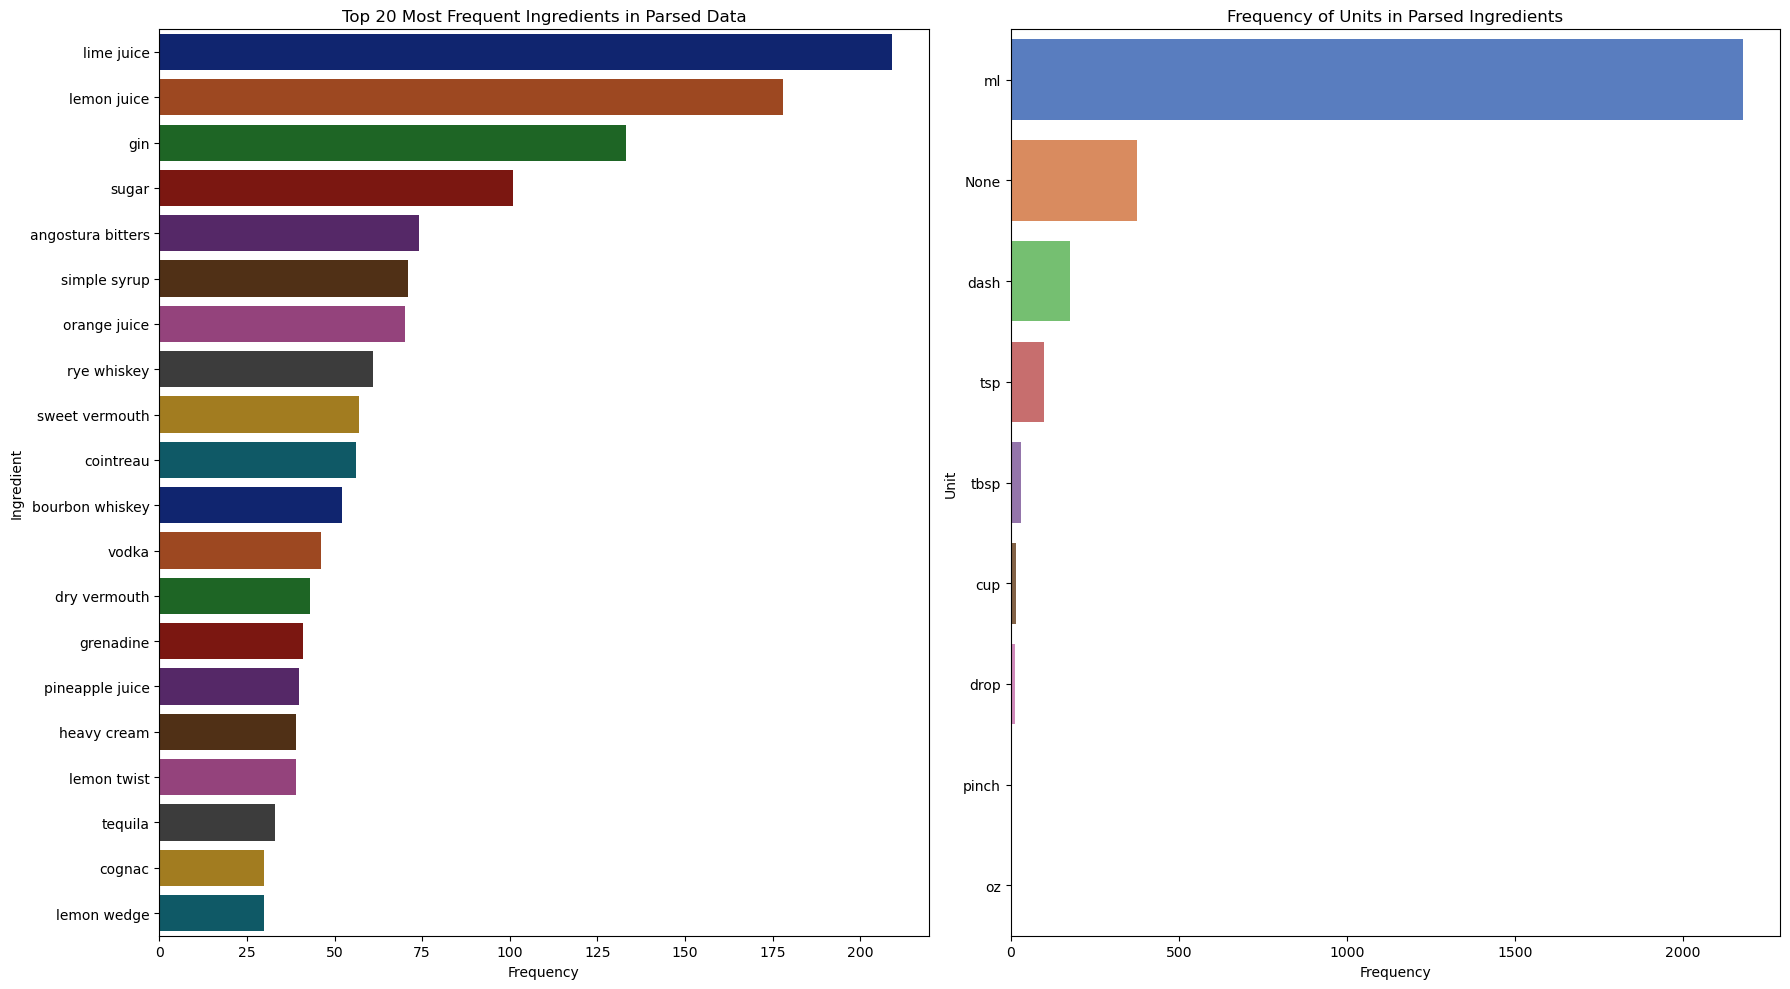

In [30]:
# Count the frequency of each ingredient and unit
ingredient_counts = parsed_df['ingredient'].value_counts().head(20)
unit_counts = parsed_df['unit'].value_counts(dropna=False)

# Replace NaN (None) with 'None' for visualization purposes
unit_counts.index = unit_counts.index.fillna('None')

# Create a figure with subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

# Plot for top 20 ingredients
sns.barplot(x=ingredient_counts.values, y=ingredient_counts.index, ax=ax[0], palette="dark", orient='h')
ax[0].set_title('Top 20 Most Frequent Ingredients in Parsed Data')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Ingredient')

# Plot for unit frequency
sns.barplot(x=unit_counts.values, y=unit_counts.index, ax=ax[1], palette="muted", orient='h')
ax[1].set_title('Frequency of Units in Parsed Ingredients')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Unit')

# Improve layout and display the plot
plt.tight_layout()
plt.show()

## Tools to Inspect

### `inspect_row` function

In [31]:
def inspect_row(modified_df, parsed_df, row_index):
    """
    Prints the title, ingredients, and directions of a given row in the modified DataFrame,
    and then prints all corresponding parsed ingredient rows from the parsed DataFrame.
    
    Parameters:
    - modified_df: pandas DataFrame containing the original cocktail data.
    - parsed_df: pandas DataFrame containing the parsed ingredients data.
    - row_index: Integer index of the row to inspect in modified_df and to match in parsed_df.
    """
    # Print details from the modified DataFrame
    print(f"Title: {modified_df.loc[row_index, 'title']}\n")
    print("Ingredients:")
    for ingredient in modified_df.loc[row_index, 'ingredients']:
        print(f"- {ingredient}")
    print("\nDirections:")
    for direction in modified_df.loc[row_index, 'directions']:
        print(f"- {direction}")
    
    # Print corresponding rows from the parsed DataFrame
    print("\nParsed Ingredients:")
    parsed_rows = parsed_df[parsed_df['recipe_id'] == row_index]
    if not parsed_rows.empty:
        print(parsed_rows.to_string(index=False))
    else:
        print("No parsed ingredients found for this recipe.")

### Using `inspect_row`

In [32]:
inspect_row(modified_df,parsed_df,264)

Title: Hot Toddy

Ingredients:
- 1 oz. sugar syrup
- 3 oz. selected liquor
- 2 or 3 cloves
- 1 dash ground cinnamon

Directions:
- 

Parsed Ingredients:
quantity unit      ingredient  ingredient_step  recipe_id
    30.0   ml           sugar                0        264
    90.0   ml selected liquor                1        264
     3.0 None          cloves                2        264
     1.0 dash ground cinnamon                3        264


In [33]:
parsed_df.iloc[651]

quantity                 22.5
unit                       ml
ingredient         lime juice
ingredient_step             1
recipe_id                 149
Name: 651, dtype: object

In [34]:
inspect_row(modified_df, parsed_df, 411)

Title: Old-Fashioned

Ingredients:
- 1-2 tsp. simple syrup
- 1-3 dashes of angostura.
- 2-4 oz. whisky

Directions:
- stir Simple Syrup and Bitters together
- add whisky and stir
- add ice, fill with whisky and stir
- Garnish with twist of Lemon and maraschino cherry on a sPear
- [Note: approx. 1 Tsp. Sugar and 1-2 Dash of Angostura for each 2 oz. of Whisky.]

Parsed Ingredients:
quantity unit   ingredient  ingredient_step  recipe_id
     2.0  tsp simple syrup                0        411
     3.0 dash   angostura.                1        411
   120.0   ml      whiskey                2        411


### Approach to look into problematic rows, creating a sub_df when a character in `ingredient` is non-alpha, non accented. For exampel '.,:-' 

In [35]:
# Create a subset of parsed_df where 'ingredient' contains unwanted non-alphabetical characters
non_alpha_df = parsed_df[parsed_df['ingredient'].str.contains(r'[^a-zA-ZàáâäãåąčćęèéêëìíîïłńòóôöõøùúûüýÿčžščșțñćßĆŚŁŻŹĆąśłżźćęóąśłżźćńŻÀÁÂÃÄÅÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿŔŕ \'-]', na=False)]

# Display the resulting DataFrame
non_alpha_df.head(50)

,quantity,unit,ingredient,ingredient_step,recipe_id
0,45.0,ml,151-proof demerara rum,0,0
73,15.0,ml,"egg white, beaten",4,18
101,30.0,ml,st. germain,2,26
160,1.0,tbsp,151-proof demerara rum,5,40
174,1.0,None,"ripe banana, peeled and sliced",4,42
212,30.0,ml,chilled 7-up,6,50
274,1.0,None,"clove garlic, finely minced",6,64
312,1.0,None,"clove garlic, finely minced",2,73
316,150.0,ml,tomato or v8 juice,6,73
356,15.0,ml,"blue curaçao """,2,81


In [36]:
non_alpha_df.tail(50)

,quantity,unit,ingredient,ingredient_step,recipe_id
1152,15.0,ml,"brandy, rum, or both",0,265
1168,60.0,ml,bacardi 8 rum,0,270
1172,7.5,ml,rothman & winter orchard apricot,4,270
1210,3.0,dash,peychaud’s bitters,3,277
1321,,ml,smith & cross rum,0,304
1363,60.0,ml,zacapa 23-year rum,0,314
1365,3.0,dash,peychaud’s bitters,2,314
1383,75.0,ml,elijah craig 12,0,318
1400,1.0,dash,peychaud’s bitters,5,321
1448,60.0,ml,17-year j. wray nephew jamaican rum,0,331


### none_rows call

In [37]:
# Filter rows and reset index 
none_rows = parsed_df.loc[parsed_df['quantity'].isnull() | parsed_df['unit'].isnull()].reset_index(drop=True)

# Display the filtered dataframe
none_rows

,quantity,unit,ingredient,ingredient_step,recipe_id


In [38]:
none_rows.loc[none_rows['ingredient_step'] == 0]

,quantity,unit,ingredient,ingredient_step,recipe_id


In [39]:
none_rows.loc[none_rows['ingredient_step'] == 0]

,quantity,unit,ingredient,ingredient_step,recipe_id


### Future tools/calls to look into problems

Can leave this empty for now, just putting in a space here for futureproofing the cleanliness

# Save completed parsed_df

In [40]:
# Save parsed_df to a CSV file
parsed_df.to_csv('clean_df.csv', index=False)
#parsed_df.to_csv('old_index_clean_df.csv', index=False)